https://www.tech-teacher.jp/blog/dimension-reduction/

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [2]:
# モデルの定義
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [3]:
# データローダーの準備
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [4]:
# 8つ画像を表示
def generate_images(autoencoder):
    with torch.no_grad():
        images, _ = next(iter(data_loader)) #images.size(): torch.Size([64, 1, 28, 28], len(_): 64
        images = images.view(images.size(0), -1) # Reshape input 2d img vector to flat vector.
        encoded, decoded = autoencoder(images)

    fig, axes = plt.subplots(1, 8, figsize=(12, 2))
    for i in range(8):
        axes[i].imshow(decoded[i].view(28, 28).cpu().numpy(), cmap='gray')
        axes[i].axis('off')
    plt.show()

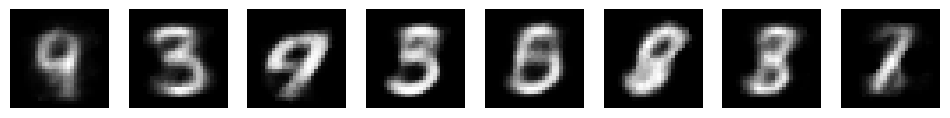

Epoch [1/5], Loss: 0.0403


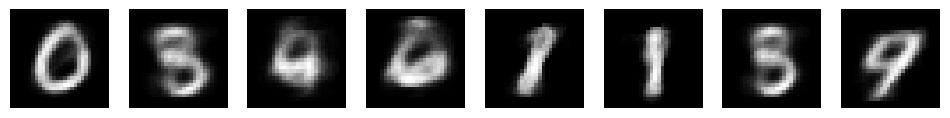

Epoch [2/5], Loss: 0.0418


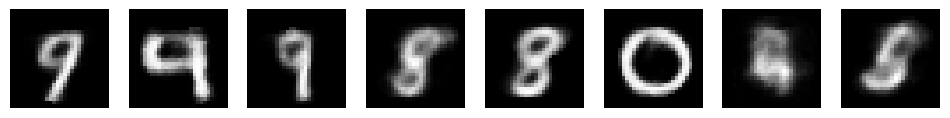

Epoch [3/5], Loss: 0.0337


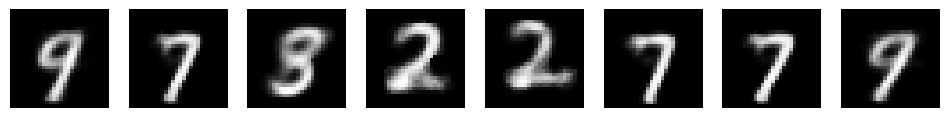

Epoch [4/5], Loss: 0.0392


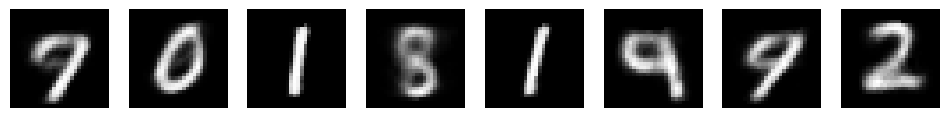

Epoch [5/5], Loss: 0.0348


In [5]:
# Autoencoderの学習
autoencoder = AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    for data in data_loader:
        img, _ = data
        img = img.view(img.size(0), -1) # Flat img vector
        _, recon_img = autoencoder(img)
        loss = criterion(recon_img, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    generate_images(autoencoder)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

2D visuzlization

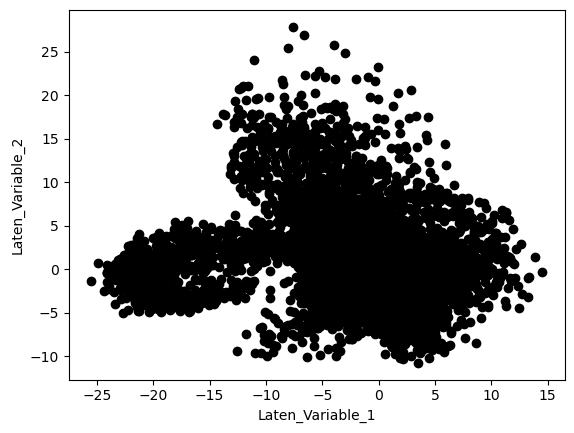

In [6]:
# 潜在変数の表示
latent_vectors = []
labels = []

for i, data in enumerate(data_loader):
    img, label = data
    img = img.view(img.size(0), -1)
    with torch.no_grad():
        latent_vector, _ = autoencoder(img)
    latent_vectors.append(latent_vector.squeeze().cpu().numpy())
    labels.extend(label.cpu().numpy())

    if i > 100:
        break

latent_tensors = [torch.tensor(arr) for arr in latent_vectors]
latent_tensors = torch.cat(latent_tensors, dim=0) # Combines latent vectors from 100 batches data.
labels_tensor = torch.tensor(labels)
unique_labels = np.unique(labels_tensor.numpy())

plt.scatter(latent_tensors[:, 0], latent_tensors[:, 1], c='black')
plt.xlabel('Laten_Variable_1')
plt.ylabel('Laten_Variable_2')
plt.show()

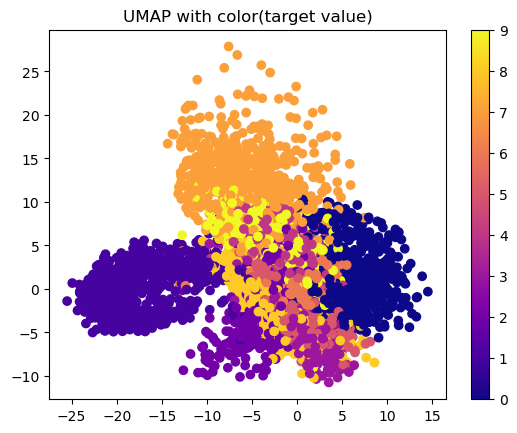

In [7]:
# Color Map with labels
sc = plt.scatter(latent_tensors[:,0],latent_tensors[:,1], vmin=np.min(unique_labels), vmax=np.max(unique_labels), c=labels_tensor, cmap=cm.plasma)
plt.colorbar(sc)
plt.title("UMAP with color(target value)")
plt.show()

3D visualization

/var/folders/5_/gc6hmj2n29l66pvrzycbx1j80000gn/T/ipykernel_3747/2177993049.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(


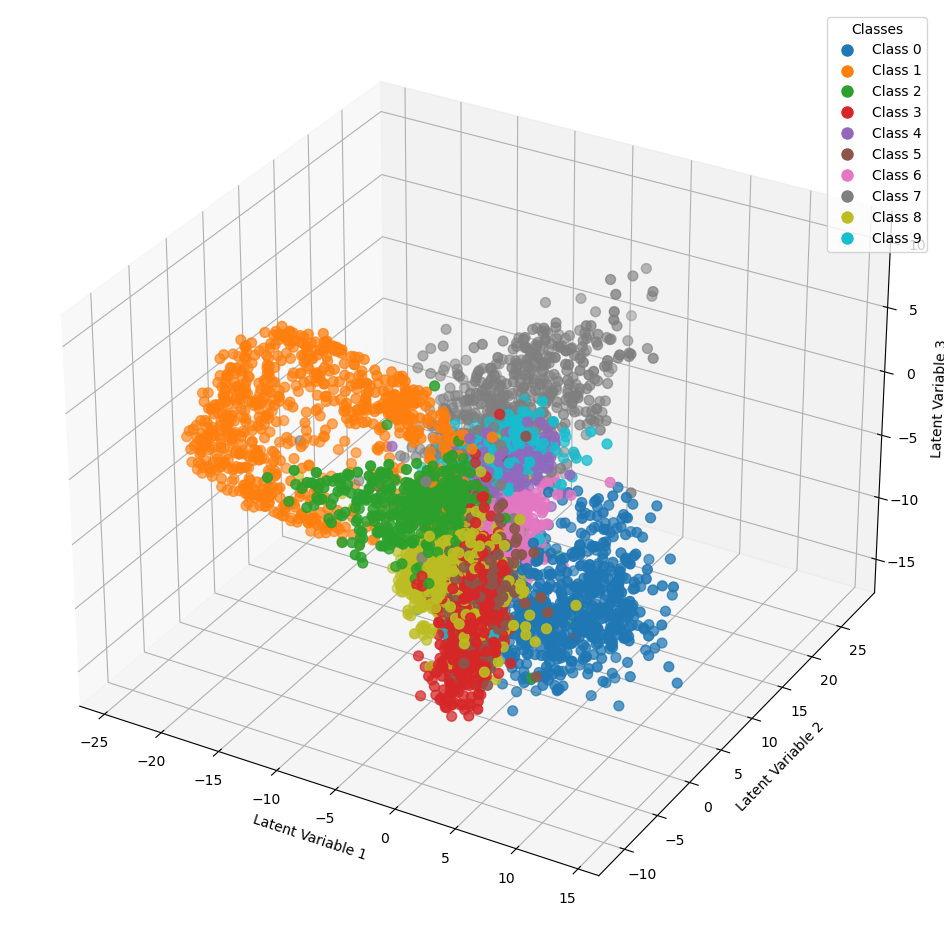

In [8]:
# 潜在変数の表示
latent_vectors = []
labels = []

for i, data in enumerate(data_loader):
    img, label = data
    img = img.view(img.size(0), -1)
    with torch.no_grad():
        latent_vector, _ = autoencoder(img)
    latent_vectors.append(latent_vector.squeeze().cpu().numpy())
    labels.extend(label.cpu().numpy())

    if i > 100:
        break

latent_tensors = [torch.tensor(arr) for arr in latent_vectors]
latent_tensors = torch.cat(latent_tensors, dim=0)
labels_tensor = torch.tensor(labels)
unique_labels = np.unique(labels_tensor.numpy())

colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
label_to_color = {label: color for label, color in zip(unique_labels, colors)}
point_colors = [label_to_color[label.item()] for label in labels_tensor]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    latent_tensors[:, 0],
    latent_tensors[:, 1],
    latent_tensors[:, 2],
    c=point_colors,
    cmap='tab10',
    s=50,
    label=labels_tensor
)

ax.set_xlabel('Latent Variable 1')
ax.set_ylabel('Latent Variable 2')
ax.set_zlabel('Latent Variable 3')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_to_color[label.item()], markersize=10, label=f'Class {label.item()}') for label in unique_labels]
ax.legend(handles=handles, title='Classes')

plt.show()